## Zadanie 1

Proszę pobrać plik medicine.txt, zawierający wyniki analizy nowego leku. W dwóch pierwszych kolumnach znajduje się stężenie dwóch składników w próbce krwi, w trzeciej - informacja o tym, czy lek zadziałał. Dane nie są znormalizowane. Proszę znormalizować dane, podzielić je na zbiór uczący i testujący w proporcjach 80-20 (należy pamiętać o proporcjach klas), zaproponować wielowarstwową sieć neuronową i zbadać jej skuteczność dla różnych ilości warstw i neuronów w tych warstwach. Proszę narysować w jaki sposób sieć dokonała podziału w zbiorze dla kilku sieci (zarówno tych z dobrymi, jak i złymi wynikami) oraz jak wygląda poprawny podział zbioru. Proszę również przedstawić wyniki dla 5-8 różnych struktur sieci, wraz z oceną, która z nich najlepiej poradziła sobie z zadaniem klasyfikacji

Architecture (5,) -> Accuracy: 0.8667
Architecture (10,) -> Accuracy: 0.8889
Architecture (10, 5) -> Accuracy: 0.8889
Architecture (50,) -> Accuracy: 0.8926
Architecture (20, 10, 5) -> Accuracy: 0.9074
Architecture (50, 30, 20, 10) -> Accuracy: 0.9074
Architecture (100,) -> Accuracy: 0.8963
Architecture (50, 25) -> Accuracy: 0.9111

Best network: (50, 25), with accuracy: 0.9111
Best network: (5,), with accuracy: 0.8667


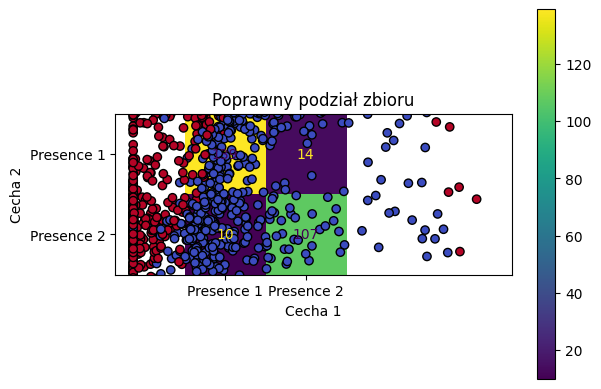

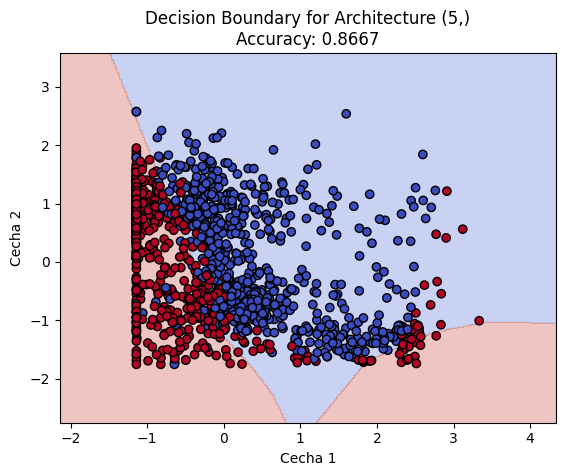

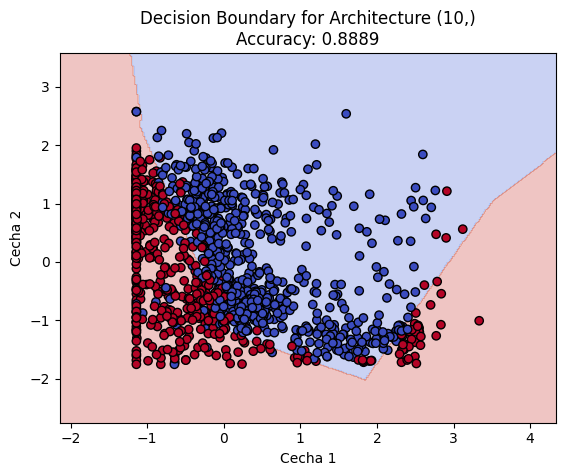

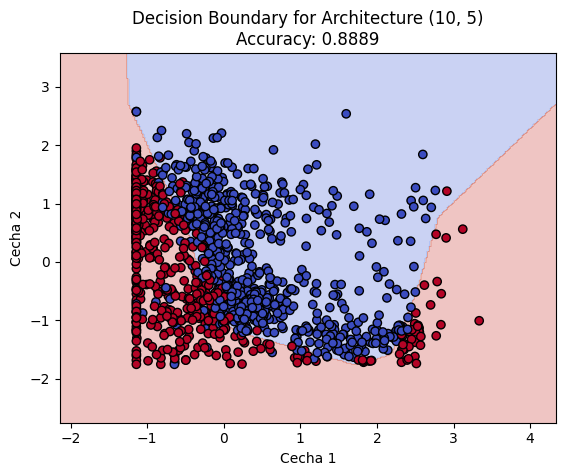

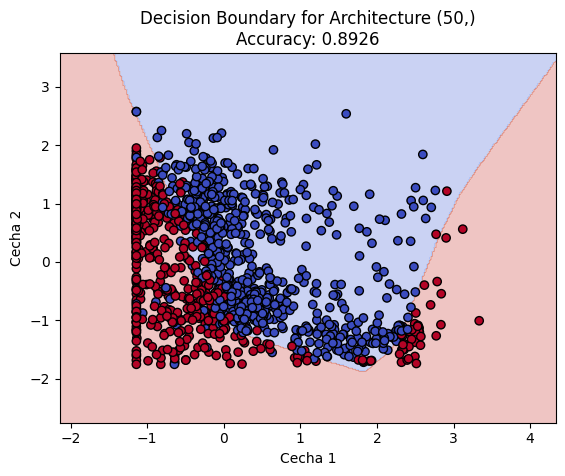

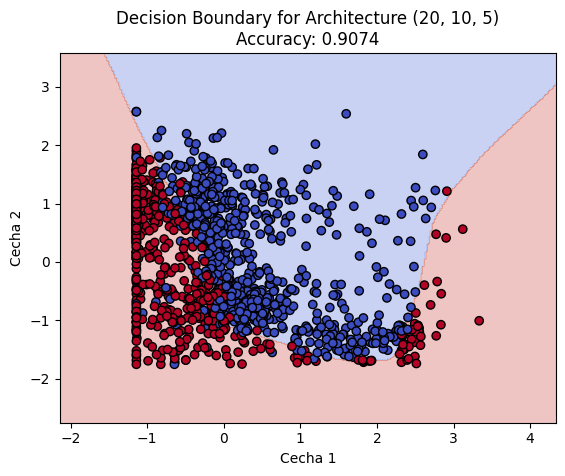

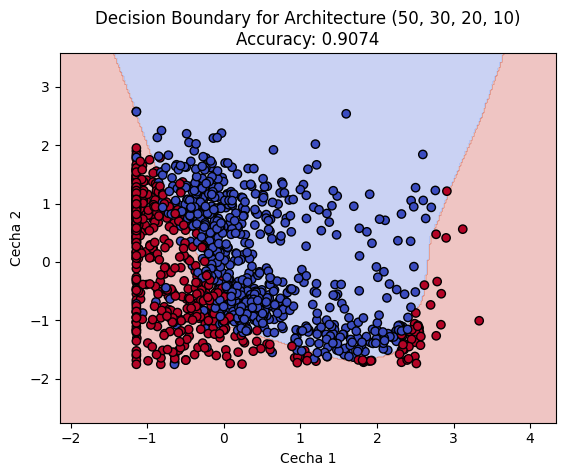

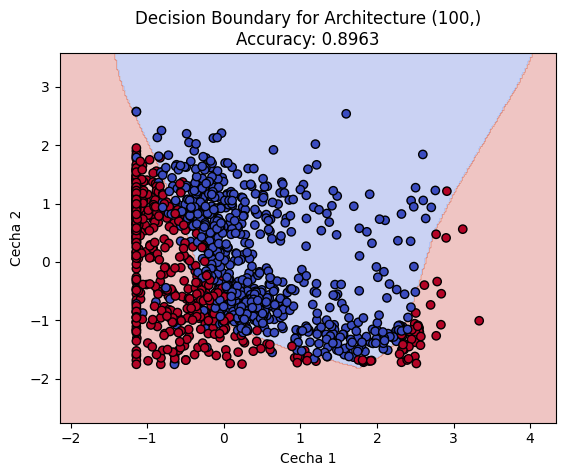

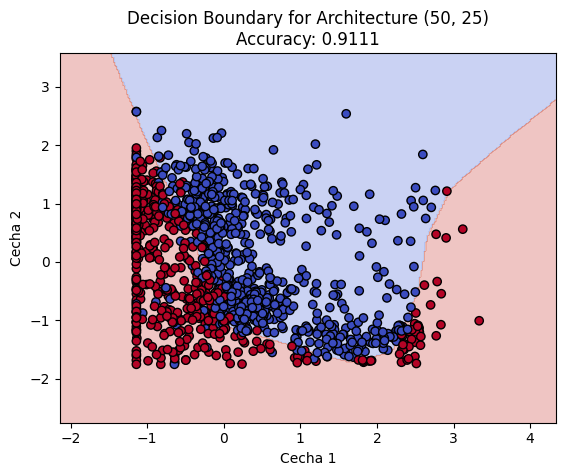

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# load data
medicine_data = pd.read_csv(os.path.join("data", "medicine.txt"))
X, y = (
    medicine_data.drop("Was medicine effective?", axis=1),
    medicine_data["Was medicine effective?"],
)

# print(medicine_data.describe())


# find outliers -> 3-sigma rule
def find_and_remove_outliers(X, y):
    n_cols, n_rows = X.shape

    feature_means = X.mean()
    feature_stdevs = X.std()

    outlier_mask = ((X < feature_means - 3 * feature_stdevs) | (X > feature_means + 3 * feature_stdevs)).any(axis=1)

    X_cleaned = X[~outlier_mask]
    y_cleaned = y[~outlier_mask]

    return X_cleaned, y_cleaned


def scale_data(X, y):
    scaler = StandardScaler()
    return scaler.fit_transform(X, y)


def prepare_data(X, y, train_size=0.8):
    X, y = find_and_remove_outliers(X, y)
    X = scale_data(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, stratify=y
    )

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = prepare_data(X, y)

# no sense in testing networks, where no of neurons increase in futher layers
architectures = [
    (5,),
    (10,),
    (10, 5),
    (50,),
    (20, 10, 5),
    (50, 30, 20, 10),
    (100,),
    (50, 25),
]

results = {}

for arch in architectures:
    mlp = MLPClassifier(hidden_layer_sizes=arch, max_iter=2000)
    mlp.fit(X_train, y_train)
    
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[arch] = accuracy
    print(f"Architecture {arch} -> Accuracy: {accuracy:.4}")

best_arch = max(results, key=results.get)
worst_arch = min(results, key=results.get)

print(f'\nBest network: {best_arch}, with accuracy: {results[best_arch]:.4}')
print(f'Best network: {worst_arch}, with accuracy: {results[worst_arch]:.4}')

# conf matrix for the best network
best_mlp = MLPClassifier(hidden_layer_sizes=best_arch, max_iter=2000)
best_mlp.fit(X_train, y_train)
y_pred_best = best_mlp.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=X)
disp.plot()
disp.ax_.set_title(f'Confusion Matrix for Best Network {best_arch}')

def plot_decision_boundary(classifier, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z = classifier.predict(grid).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    plt.title(title)
    plt.xlabel("Cecha 1")
    plt.ylabel("Cecha 2")
    plt.show()

def plot_true_boundary(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    plt.title("Poprawny podział zbioru")
    plt.xlabel("Cecha 1")
    plt.ylabel("Cecha 2")
    plt.show()

X_total = np.vstack((X_train, X_test))
y_total = np.concat([y_train, y_test])

plot_true_boundary(X_total, y_total)

for arch in architectures:
    classifier = MLPClassifier(hidden_layer_sizes=arch, max_iter=2000)
    classifier.fit(X_train, y_train)

    acc = results.get(arch, None)
    title = f"Decision Boundary for Architecture {arch}"
    if acc is not None:
        title += f"\nAccuracy: {acc:.4}"
    
    plot_decision_boundary(classifier, X_total, y_total, title)